In [1]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable, Sequence, List, Tuple, Dict, Optional
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from generators import BlenderStandardDataset, TorchStandardDataset

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Wrong GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)

In [3]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

In [4]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
SQL_TABLE = 'bboxes_std'
BATCH_SIZE = 1
LR = 2e-5
NUM_CLASSES=6
NULL_CLASS_COEF=0.5

In [5]:
torch.hub.set_dir(TORCH_CACHE_DIR)

In [6]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load(
            os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), 
            model='detr_resnet50', 
            pretrained=True,
            source='local'
        )
        
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

model = DETRModel(NUM_CLASSES, 100)
model = model.to(device)

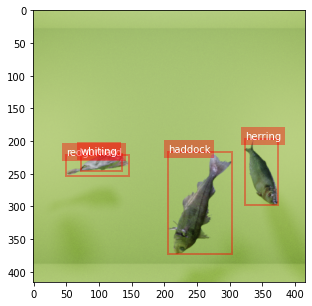

In [7]:
datagen = BlenderStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False)
datagen.plot_batch(0)

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    mean = np.array([0.64817397, 0.75178422, 0.43881263])
    std = np.array([0.06833826, 0.07720845, 0.05868721])
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [11]:
weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
losses = ['labels', 'boxes', 'cardinality']
matcher = HungarianMatcher()
criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

torchgen = TorchStandardDataset(DATASET_DIR, SQL_TABLE, BATCH_SIZE, shuffle=False)

dataloader = DataLoader(
    dataset=torchgen, 
    batch_size=4, 
    collate_fn=lambda x: tuple(zip(*x)), 
)

train_fn(
    data_loader=dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    scheduler=None,
    epoch=0
)


KeyboardInterrupt: 